# (Self Study) Boosted Trees: Gradient Boosting

In this notebook we'll implement Gradient Boosting.

This includes the following steps:
1. Generate data and use`sklearn`'s Gradient Boosting
1. Manually implement Gradient Boosting
1. Study Gradient Boosting learning progress by iteration

## Background

<img src="https://raw.githubusercontent.com/sbstn-gbl/learning-from-big-data/master/source/_static/img/gradient-boosting.png" width="1000">


In [1]:
import celluloid
import common
import matplotlib.pyplot as plt
import numpy as np
import sklearn.ensemble
import sklearn.tree

plt.rcParams.update(
    {
        "figure.figsize": (8, 5),
        "axes.titlesize": 18,
        "axes.labelsize": 14,
        "legend.fontsize": 14,
        "axes.grid": True,
        "axes.axisbelow": True,
        "pcolor.shading": "auto",
    }
)

## Data

Five blobs of data for different `x` ranges at different levels for `y`.

This very artificial data set allows us to visualize nicely how gradient boosting works.

In [2]:
# define data
N = 100
config = {
    "n": [17, 18, 15, 22, 28],
    "limits": [[10, 15], [20, 25], [0, 5], [30, 32], [13, 17]],
}

In [3]:
# generate data
y = np.hstack(
    [
        np.random.uniform(
            config["limits"][i][0], config["limits"][i][1], config["n"][i]
        )
        for i in range(len(config["limits"]))
    ]
)
X = np.arange(N)[:, np.newaxis]

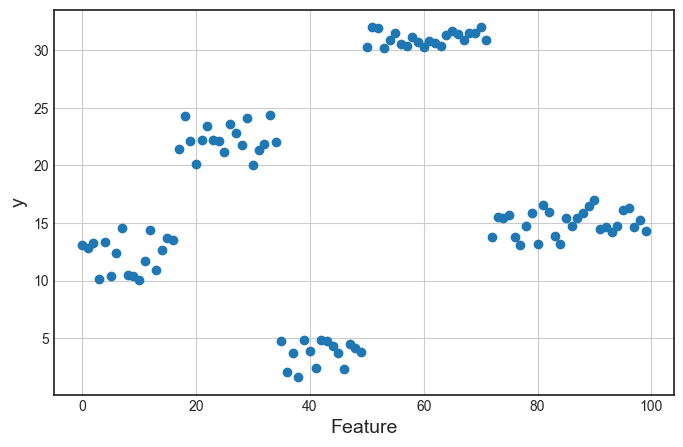

In [4]:
# plot
plt.scatter(X, y)
plt.xlabel("Feature")
plt.ylabel("y")
plt.show()

<br> 

## Reference solution in `sklearn`

The perfect model would follow the true data generating process:
- Predict five different `y` levels, depending on `x`
- The gradient boosting machine is capable of uncovering this pattern
- Note the overfitting within each blob, the model fits noise

In [5]:
gbm_sklearn = sklearn.ensemble.GradientBoostingRegressor(
    learning_rate=0.8,
    n_estimators=50,
    max_depth=1,
    max_leaf_nodes=2,
)
gbm_sklearn = gbm_sklearn.fit(X, y)

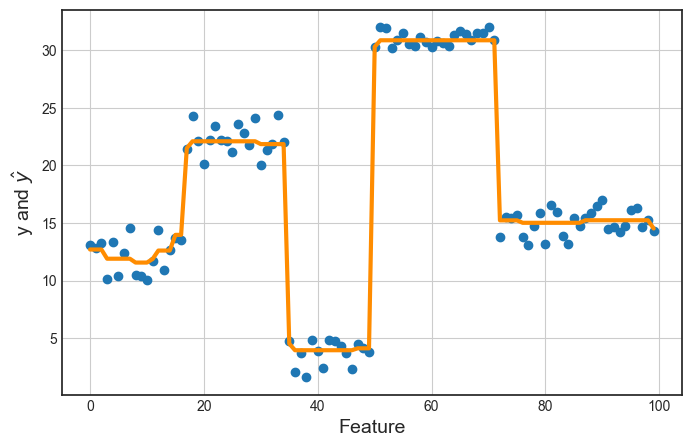

In [6]:
plt.scatter(X, y)
plt.plot(X, gbm_sklearn.predict(X), c="darkorange", linewidth=3)
plt.xlabel("Feature")
plt.ylabel(r"y and $\hat y$")
plt.show()

<br> 

## Manual implementation

In [7]:
class GradientBoosting(object):
    def __init__(
        self,
        n_estimators,
        learning_rate,
    ):

        self.n_estimators = n_estimators
        self.learning_rate = learning_rate

        # initialize regression trees
        # note that we fix the trees to stumps
        self.trees = []
        for _ in range(n_estimators):
            tree = sklearn.tree.DecisionTreeRegressor(
                max_leaf_nodes=2,
                max_depth=1,
            )
            self.trees.append(tree)

        self.residuals = np.zeros((self.n_estimators, len(y)))
        self.gradients = np.zeros((self.n_estimators, len(y)))
        self.predictions = np.zeros((self.n_estimators, len(y)))

    def fit(self, X, y):
        y_pred = np.zeros(len(y))
        for i in range(self.n_estimators):
            self.residuals[i] = y - y_pred
            gradient = self._gradient(y, y_pred)
            self.gradients[i] = gradient
            self.trees[i].fit(X, gradient)
            # note that we use `-=` to iteratively update y_pred!
            y_pred -= np.multiply(self.learning_rate, self.trees[i].predict(X))
            self.predictions[i] = y_pred

    def predict(self, X, I=None):
        y_pred = np.zeros(X.shape[0])
        for tree in self.trees:
            # note that we use `-=` to iteratively update y_pred!
            y_pred -= np.multiply(self.learning_rate, tree.predict(X))
        return y_pred

    def _gradient(self, y, y_pred):
        # mean square error loss `MSE = (y-y_pred)^2`
        # we introduce an additional scaling factor of 1/2 -> `MSE = 1/2*(y-y_pred)^2`
        # then, the gradient wrt y_pred is `partial_y_pred = -(y-y_pred)`
        return -(y - y_pred)

In [8]:
gradient_boosting = GradientBoosting(
    n_estimators=50,
    learning_rate=1.2,
)
gradient_boosting.fit(X, y)

## Plot by iteration

In [9]:
n_estimators = 100

gradient_boosting = GradientBoosting(
    n_estimators=n_estimators,
    learning_rate=1,
)
gradient_boosting.fit(X, y)

y_pred_all = np.zeros((gradient_boosting.n_estimators, X.shape[0]))
for i, tree in enumerate(gradient_boosting.trees):
    y_pred_all[i] = y_pred_all[i - 1] - np.multiply(
        gradient_boosting.learning_rate, tree.predict(X)
    )

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(20, 5))

ax1.set_xlabel("Feature")
ax1.set_ylabel(r"y and $\hat y$")

ax2.set_xlabel("Feature")
ax2.set_ylabel(r"y - $\hat y$")

camera = celluloid.Camera(fig)

for i, iter in enumerate(range(n_estimators)):
    ax1.plot(X.flatten(), y_pred_all[i], c="darkorange", linewidth=3)
    ax1.legend([f"Epoch: {iter}"], loc="upper left")
    ax1.plot(X.flatten(), y, "o", c="darkblue")
    ax2.plot(X.flatten(), gradient_boosting.residuals[i], "go")
    ax2.set_ylim(-20, 40)
    plt.tight_layout()
    camera.snap()

plt.close()

anim_lr_1d = camera.animate()

# anim_lr_1d.save("gradient-boosting.gif", writer="pillow", dpi=150, fps=2)

### GIF animation

- Note how first gradients change "by blob" (that is the desired bias reduction)
- Then, gradients start updating individual points or small group of points (this is overfitting and not desired)

<img src="https://raw.githubusercontent.com/sbstn-gbl/learning-from-big-data/master/source/_static/img/gradient-boosting.gif" width="1400">

<br>
<br>
<b>Learning from Big Data</b> <br>
Sebastian Gabel <br>

<br>

[1] Inspired by [this source](https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d)